In [1]:
from annotated_data.data import AbductiveNLIExample, AnnotatedAbductiveSet, ParaphrasedAbductiveNLIExample
from experiments.auto_vs_human.parse_paraphrases import *
from Levenshtein import setratio, seqratio
from tqdm import tqdm
from nltk.metrics.distance import edit_distance
import numpy as np
from collections import Counter
import pandas as pd
from experiments.models import TrainedModel
from nltk.tokenize import word_tokenize
import Levenshtein
from datasets import load_metric
import bert_score
import plotly.express as px
from scipy.stats import pearsonr
from annotated_data.data import pilot_annotated_abductive_set, ParaphrasedAbductiveNLIExample

roberta_large = TrainedModel(
    'modeling/chkpts/roberta-large-anli/',
    cache_dir='modeling/hf-cache/',
)
syntdiv = load_metric("experiments/syntdiv_metric.py", experiment_id=0)

automatic = parse_validated_gpt3_paraphrases(parse_validated_qcpg_paraphrases())
human = pilot_annotated_abductive_set.zipped_intra_worker_paraphrases

/Users/nehasrikanth/miniconda3/envs/para-nlu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from modeling/chkpts/roberta-large-anli/


[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /Users/nehasrikanth/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!


In [2]:
def get_prediction(obs1, obs2, hyp1, hyp2, argmax=True):
    pred = roberta_large._get_prediction(
        obs1=obs1, obs2=obs2, hyp1=hyp1, hyp2=hyp2
    )
    if argmax: 
        return np.argmax(pred) + 1
    return pred

def get_lexical_diversity_score(prediction, reference):
    pred, ref = word_tokenize(prediction.lower()), word_tokenize(reference.lower())
    set_diversity = 1 - setratio(pred, ref)
    seq_diversity = 1 - seqratio(pred, ref)
    return (set_diversity + seq_diversity) / 2 

def pairwise_metrics(e: ParaphrasedAbductiveNLIExample, original_pred, para_pred, source=None):
    h1_diff = get_lexical_diversity_score(e.hyp1_paraphrase.lower(), e.original_example.hyp1.lower())
    h2_diff = get_lexical_diversity_score(e.hyp2_paraphrase.lower(), e.original_example.hyp2.lower())
    lexical_diversity = (h1_diff + h2_diff) / 2
    
    
    syntactic_diversity = syntdiv.compute(predictions=[e.hyp1_paraphrase.lower(), e.hyp2_paraphrase.lower()], 
                    references=[e.original_example.hyp1.lower(), e.original_example.hyp2.lower()])["scores"]
    
    pred_shift = original_pred[e.original_example.label - 1] - para_pred[e.original_example.label - 1]
    
    return {
        'paraphrased_example': e,
        'lexical_div_h1': h1_diff,
        'lexical_div_h2': h2_diff,
        'syntactic_div_h1': syntactic_diversity[0],
        'syntactic_div_h2': syntactic_diversity[1],
        'original_prediction': original_pred,
        'paraphased_prediction': para_pred,
        'lexical_diversity': lexical_diversity,
        'syntactic_diversity': (syntactic_diversity[0] + syntactic_diversity[1]) / 2,
        'absolute_pred_shift': abs(pred_shift),
        'pred_shift': pred_shift,
        'model': source
    }

In [3]:
def calculate_bert_score(examples):
    candidates = []
    refs = []

    for e in examples:
        candidates.append(e['paraphrased_example'].hyp1_paraphrase.lower())
        candidates.append(e['paraphrased_example'].hyp2_paraphrase.lower())
        refs.append([e['paraphrased_example'].original_example.hyp1.lower()])
        refs.append([e['paraphrased_example'].original_example.hyp2.lower()])

    _ , _ , bs = bert_score.score(candidates, refs, lang='en', rescale_with_baseline=True)
    
    bs_i = 0
    for i in range(len(examples)):
        examples[i]['semantic_similary_h1'] = bs[bs_i].item()
        examples[i]['semantic_similary_h2'] = bs[bs_i + 1].item()
        examples[i]['semantic_similarity'] = (bs[bs_i].item() + bs[bs_i + 1].item()) / 2
        bs_i += 2

In [4]:
auto_pairwise = []

for example in tqdm(automatic):
    
    qcpg = list(zip(example.annotated_paraphrases[0]['hyp1_paraphrases'], example.annotated_paraphrases[0]['hyp2_paraphrases']))
    gpt3 = list(zip(example.annotated_paraphrases[1]['hyp1_paraphrases'], example.annotated_paraphrases[1]['hyp2_paraphrases']))
    
    if len(qcpg) + len(gpt3) < 1:
        continue
        
    original_prediction = get_prediction(example.obs1, example.obs2, example.hyp1, example.hyp2, argmax=False)
    
    qcpg_bucket = [
        (ParaphrasedAbductiveNLIExample(
            paraphrase_id='validated.%s'% example.example_id,
            original_example=example,
            original_example_id=example.example_id,
            hyp1_paraphrase=p[0],
            hyp2_paraphrase=p[1],
        ), 'qcpg')
        for p in qcpg
    ]
    
    gpt3_bucket = [
        (ParaphrasedAbductiveNLIExample(
            paraphrase_id='validated.%s'% example.example_id,
            original_example=example,
            original_example_id=example.example_id,
            hyp1_paraphrase=p[0],
            hyp2_paraphrase=p[1],
        ), 'gpt3')
        for p in gpt3
    ]
    
    bucket = qcpg_bucket + gpt3_bucket
    
    bucket_predictions = [
        get_prediction(
            e.original_example.obs1,
            e.original_example.obs2,
            e.hyp1_paraphrase,
            e.hyp2_paraphrase,
            argmax=False
        )
        for e, source in bucket
    ]
    
    for i, (e, source) in enumerate(bucket):
        auto_pairwise.append(pairwise_metrics(e, original_prediction, bucket_predictions[i], source=source))
    

  0%|                                                                                       | 0/115 [00:00<?, ?it/s]/Users/nehasrikanth/miniconda3/envs/para-nlu/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1352.35it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1457.62it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 729.13it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1304.81it/s]

syntdiv:calc_di

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 915.79it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 861.43it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1206.47it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1004.62it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 966.21it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 844.94it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 909.83it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 608.27it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1256.16it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 897.27it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 977.12it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 832.37it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1241.47it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 881.53it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 923.75it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 779.39it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 671.63it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 791.75it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1074.64it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 706.23it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 693.73it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 817.68it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 767.20it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 842.82it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 561.64it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 657.88it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 802.28it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 758.40it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 843.50it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 736.42it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 757.03it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 993.56it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 584.61it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 896.41it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 678.47it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 620.73it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 937.17it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 613.88it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 889.28it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 535.47it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 353.86it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1081.84it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1322.71it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 856.16it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1370.69it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1204.91it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1455.60it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1275.45it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1168.82it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 810.96it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 924.67it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 795.88it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 791.45it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1164.11it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 830.97it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 766.01it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 519.61it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 634.30it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 661.41it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 750.46it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 753.83it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 679.13it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 737.14it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 748.45it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 624.99it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 626.16it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 654.44it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 620.92it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 556.20it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 975.65it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 899.39it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1041.67it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 531.77it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 582.42it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 693.73it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 536.60it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 670.02it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 653.83it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 730.21it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 494.79it/s]

syntdiv:calc_dist: 100%|████████████████████████████████


syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1024.13it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1136.98it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 886.18it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 938.53it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1226.94it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 966.10it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1198.20it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1088.72it/s]

syntdiv:calc_dist: 100%|███████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 759.56it/s]

syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1078.78it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 802.51it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 606.03it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 674.33it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 656.39it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 576.34it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 586.82it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 570.96it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 524.35it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 640.60it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 642.61it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 718.39it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 631.67it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 603.84it/s]

syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 715.57it/s]

syntdiv:calc_dist: 100%|████████████████████████████████

In [6]:
human_pairwise = []

for e in tqdm(human):
    original_prediction = get_prediction(e.original_example.obs1, e.original_example.obs2, e.original_example.hyp1, e.original_example.hyp2, argmax=False)
    para_pred = get_prediction(e.original_example.obs1, e.original_example.obs2, e.hyp1_paraphrase, e.hyp2_paraphrase, argmax=False)
    
    human_pairwise.append(pairwise_metrics(e, original_prediction, para_pred, source='human'))


  3%|██▌                                                                          | 34/1035 [00:14<07:27,  2.24it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 858.78it/s]


 10%|███████▌                                                                    | 103/1035 [00:42<06:31,  2.38it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 900.55it/s]


 17%|████████████▋                                                               | 172/1035 [01:12<06:23,  2.25it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 804.82it/s]


 23%|█████████████████▋                                                          | 241/1035 [01:41<05:34,  2.37it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 863.65it/s]


 30%|██████████████████████▊                                                     | 310/1035 [02:10<04:51,  2.48it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 796.11it/s]


 37%|███████████████████████████▊                                                | 379/1035 [02:39<04:17,  2.55it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 949.58it/s]


 43%|████████████████████████████████▉                                           | 448/1035 [03:08<04:08,  2.37it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 960.56it/s]


 50%|█████████████████████████████████████▉                                      | 517/1035 [03:37<03:42,  2.33it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 475.38it/s]


 57%|███████████████████████████████████████████                                 | 586/1035 [04:06<03:07,  2.40it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 643.54it/s]


 63%|████████████████████████████████████████████████                            | 655/1035 [04:35<02:37,  2.41it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 710.96it/s]


 70%|█████████████████████████████████████████████████████▏                      | 724/1035 [05:03<02:00,  2.59it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 734.75it/s]


 77%|██████████████████████████████████████████████████████████▏                 | 793/1035 [05:31<01:40,  2.40it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 884.22it/s]


 83%|███████████████████████████████████████████████████████████████▎            | 862/1035 [06:00<01:10,  2.46it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 724.40it/s]


 90%|████████████████████████████████████████████████████████████████████▎       | 931/1035 [06:29<00:46,  2.25it/s]


syntdiv:calc_dist: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 488.28it/s]


 97%|████████████████████████████████████████████████████████████████████████▍  | 1000/1035 [06:57<00:13,  2.59it/s]


syntdiv:calc_dist: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1506.30it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1035/1035 [07:11<00:00,  2.40it/s]


In [13]:
calculate_bert_score(auto_pairwise)
calculate_bert_score(human_pairwise)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaM

In [14]:
auto_df = pd.DataFrame(auto_pairwise)
human_df = pd.DataFrame(human_pairwise)

In [15]:
auto_df['consistent'] = auto_df.apply(lambda row: int((np.argmax(row.original_prediction) + 1) == np.argmax(row.paraphased_prediction) +1) ,axis=1)
human_df['consistent'] = human_df.apply(lambda row: int((np.argmax(row.original_prediction) + 1) == np.argmax(row.paraphased_prediction) +1) ,axis=1)

In [16]:
auto_df

,paraphrased_example,lexical_div_h1,lexical_div_h2,syntactic_div_h1,syntactic_div_h2,original_prediction,paraphased_prediction,lexical_diversity,syntactic_diversity,absolute_pred_shift,pred_shift,model,semantic_similary_h1,semantic_similary_h2,semantic_similarity,consistent
0,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.377778,0.137037,0.176471,0.294118,"[4.5881432e-08, 1.0]","[6.8688615e-07, 0.99999905]",0.257407,0.235294,9.536743e-07,9.536743e-07,qcpg,0.803881,0.868325,0.836103,1
1,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.262963,0.262963,0.176471,0.176471,"[4.5881432e-08, 1.0]","[9.374694e-08, 1.0]",0.262963,0.176471,0.000000e+00,0.000000e+00,qcpg,0.834485,0.907709,0.871097,1
2,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.343137,0.289286,0.000000,0.157895,"[4.5881432e-08, 1.0]","[5.9371132e-08, 1.0]",0.316211,0.078947,0.000000e+00,0.000000e+00,gpt3,0.825527,0.854804,0.840166,1
3,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.098124,0.107143,0.000000,0.000000,"[4.5881432e-08, 1.0]","[9.020698e-08, 1.0]",0.102633,0.000000,0.000000e+00,0.000000e+00,gpt3,0.973512,0.964623,0.969068,1
4,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.107143,0.207143,0.000000,0.157895,"[4.5881432e-08, 1.0]","[2.9308288e-07, 1.0]",0.157143,0.078947,0.000000e+00,0.000000e+00,gpt3,0.955782,0.881241,0.918512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.384170,0.301905,0.103448,0.103448,"[0.9993569, 0.0006431923]","[0.3775989, 0.6224012]",0.343037,0.103448,6.217580e-01,6.217580e-01,qcpg,0.622509,0.718641,0.670575,0
804,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.316919,0.333819,0.103448,0.103448,"[0.9993569, 0.0006431923]","[0.26138127, 0.7386187]",0.325369,0.103448,7.379757e-01,7.379757e-01,qcpg,0.683907,0.652140,0.668024,0
805,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.120000,0.073485,0.000000,0.000000,"[0.9993569, 0.0006431923]","[0.97671837, 0.023281509]",0.096742,0.000000,2.263856e-02,2.263856e-02,gpt3,0.849987,0.888936,0.869461,1
806,ParaphrasedAbductiveNLIExample(paraphrase_id='...,0.140245,0.097058,0.033333,0.000000,"[0.9993569, 0.0006431923]","[0.9396019, 0.06039805]",0.118651,0.016667,5.975503e-02,5.975503e-02,gpt3,0.764915,0.926831,0.845873,1


In [ ]:
fig = px.histogram(auto_df, x="semantic_similarity", color="consistent", barmode="overlay")
fig.show()

#fig.write_html("experiments/auto_vs_human/syntactic_div_consistency_auto.html")

In [18]:
all_paraphrases = pd.concat([auto_df, human_df])

In [ ]:
all_paraphrases['syn_lex_div'] = all_paraphrases['lexical_diversity'] + all_paraphrases['syntactic_diversity']

In [19]:
all_paraphrases['original_prediction_confidence'] = all_paraphrases.apply(
    lambda r: r.original_prediction[r.paraphrased_example.original_example.label - 1], axis=1
)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

step = 0.1

for original_confidence_interval in np.arange(0, 1, step):
    l_bound = original_confidence_interval
    r_bound = original_confidence_interval + step
    
    temp = all_paraphrases[
        (all_paraphrases.original_prediction_confidence > l_bound) & 
            (all_paraphrases.original_prediction_confidence < r_bound) &
        (~all_paraphrases.model.isin(['human']))
    ]
    if temp.empty:
        continue
        
    corr, pval = pearsonr(temp.syn_lex_div.values, temp.absolute_pred_shift.values)
    
    

    fig = px.scatter(
        temp, 
        x="syn_lex_div", 
        y="absolute_pred_shift", 
        color="model", 
        title='Original Confidence: (%.1f, %.1f)' % (l_bound, r_bound))
    
    fig.add_trace(go.Scatter(
        x=[0.3],
        y=[1],
        mode="text",
        text=["ρ=%.2f (pval=%.2f)" % (corr, pval)],
        textposition="top center"
    ))
    fig.show()



In [ ]:
import plotly.express as px
fig = px.scatter_3d(temp, x='lexical_diversity', y='syntactic_diversity', z='absolute_pred_shift',
              color='model')
fig.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats


In [ ]:
all_paraphrases

In [ ]:
X = all_paraphrases[[
    'lexical_div_h1',
    'lexical_div_h2',
    'syntactic_div_h1',
    'syntactic_div_h2',
    'semantic_similary_h1',
    'semantic_similary_h2',
    'syn_lex_div'
]].values
y = all_paraphrases['absolute_pred_shift'].values

est = sm.OLS(y, X)
linear_model = est.fit()
linear_model.summary()

### Bucket Level 

In [ ]:
def plot_buckets(independent_var):
    buckets = defaultdict(list)
    for _, e in all_paraphrases.iterrows():
        buckets[e.paraphrased_example.original_example_id].append(
            (e[independent_var], e.absolute_pred_shift)
        )
    
    bucket_plot = []

    for _, bvals in buckets.items():
        bucket_plot.append({
            'avg_div': sum(x[0] for x in bvals) / len(bvals),
            'avg_shift': sum(x[1] for x in bvals) / len(bvals)
        })
    
    buckets_ = pd.DataFrame(bucket_plot)
    print(pearsonr(buckets_.avg_div.values, buckets_.avg_shift.values))

    fig = px.scatter(buckets_, x="avg_div", y="avg_shift", trendline="ols")

    fig.show()

In [ ]:
plot_buckets('semantic_similarity')

In [ ]:
plot_buckets('lexical_diversity')

In [ ]:
plot_buckets('syntactic_diversity')

In [ ]:
plot_buckets('syn_lex_div')

In [25]:
buckets = {}
for _, e in all_paraphrases.iterrows():
    buckets[e.paraphrased_example.original_example_id] = e.original_prediction_confidence

<AxesSubplot:ylabel='Frequency'>

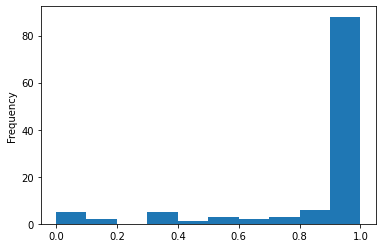

In [30]:
pd.Series(list(buckets.values())).plot.hist()

In [31]:
pd.Series(list(buckets.values())).describe()

count    115.000000
mean       0.870224
std        0.266820
min        0.000118
25%        0.907198
50%        0.998715
75%        0.999981
max        1.000000
dtype: float64